Epoch 5 | Loss 17800.16211
Epoch 10 | Loss 17789.83008
Epoch 15 | Loss 17778.82422
Epoch 20 | Loss 17766.59375
LSTM RMSE: 135.5046


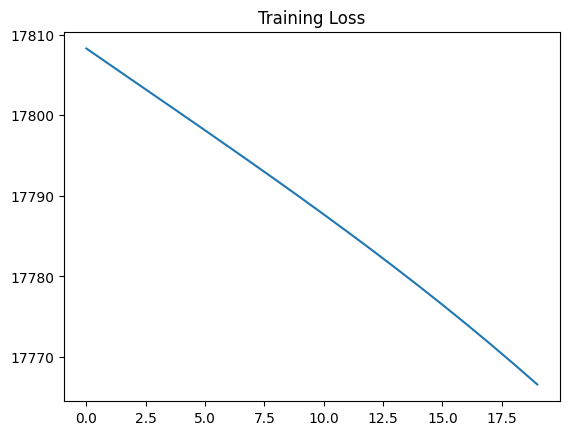

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

df = pd.read_csv("/content/pm25_processed.csv", index_col=0)

target = 'pm2.5'
X = df.drop(columns=[target])
y = df[target]

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

X_train_t = torch.FloatTensor(X_train_s).unsqueeze(1)
X_test_t = torch.FloatTensor(X_test_s).unsqueeze(1)
y_train_t = torch.FloatTensor(y_train.values).view(-1,1)
y_test_t = torch.FloatTensor(y_test.values).view(-1,1)

class AirModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, 64, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1])

model = AirModel(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20
losses = []

for e in range(epochs):
    optimizer.zero_grad()
    out = model(X_train_t)
    loss = criterion(out, y_train_t)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if (e+1) % 5 == 0:
        print(f"Epoch {e+1} | Loss {loss.item():.5f}")

model.eval()
with torch.no_grad():
    preds = model(X_test_t)

rmse = np.sqrt(mean_squared_error(y_test, preds.numpy()))
print(f"LSTM RMSE: {rmse:.4f}")

plt.plot(losses)
plt.title("Training Loss")
plt.show()
